In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [11]:
data= pd.read_csv("BoxBOD_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,109,1
NaN,149,2
NaN,149,3
NaN,191,5
NaN,213,7
NaN,224,10


In [12]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

# b = torch.tensor([1.0,1.0],requires_grad=True)
b = torch.tensor([100.0,0.75],requires_grad=True)

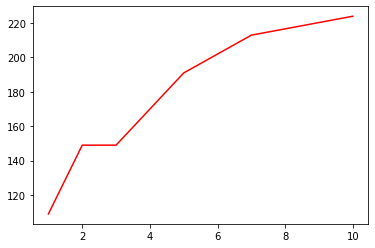

In [13]:
plt.plot(x.numpy(),y.numpy(),"r")

In [14]:
## Numerical Differentiation

b = np.array([1.0,1.0]).reshape(-1,1)
b = np.array([100.0,0.75]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0



def f0(b0):
    return  b0*(1-np.exp((-b[1]*x))) -y.detach().numpy()  
def f1(b1):
    return b[0]*(1-np.exp((-b1*x)))-y.detach().numpy()  

start_time = time.perf_counter()
for c in range(500):
    
    y_pred = b[0]*(1-np.exp((-b[1]*x)))
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
     
    jacobian = np.transpose(np.array([d_b0,d_b1]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    if V < 1.1680088766E+03:
        break
print("time taken to execute: ",time.perf_counter()-start_time)    

c:  0  error:  48785.25266563878  B: [[205.22775556]
 [  0.45353028]]
c:  1  error:  2645.9165493332093  B: [[210.94088212]
 [  0.54773236]]
c:  2  error:  1200.7178282320917  B: [[213.65841885]
 [  0.54822677]]
c:  3  error:  1168.0471591231565  B: [[213.79050901]
 [  0.54745149]]
c:  4  error:  1168.009839731233  B: [[213.80547005]
 [  0.54728306]]
c:  5  error:  1168.0089202202078  B: [[213.80857185]
 [  0.54724719]]
c:  6  error:  1168.0088785346054  B: [[213.80923084]
 [  0.54723955]]
c:  7  error:  1168.0088766451977  B: [[213.80937108]
 [  0.54723792]]
c:  8  error:  1168.008876559605  B: [[213.8094008 ]
 [  0.54723758]]
time taken to execute:  0.008330599999993638


In [15]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [16]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(50):
    
    y_pred = b[0]*(1-torch.exp((-b[1]*x)))
    
    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error < 1.1680088766E+03:
        break
print("time taken to execute: ",time.perf_counter()-start_time)  

TypeError: exp(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
plt.plot(y_pred.detach(),'g', y,'r')

In [ ]:
 y   